# Environment

In [1]:
import google.cloud.bigquery as bigquery, pandas as pd, matplotlib.pyplot as plt, seaborn as snsn, numpy as np, importlib

In [2]:
import src.utils.evaluation as evaluation

In [3]:
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    cohen_kappa_score,
    roc_auc_score,
)

# Data

In [4]:
client = bigquery.Client()

In [5]:
query = """
SELECT
  *
FROM
  stackoverflow.posts_preprocessed_selection
WHERE RAND() <= 0.25
"""

In [6]:
df = client.query(query).to_dataframe()

In [7]:
df.head()

,id,title,text_body,code_body,tags
0,26438108,ios swift didbegincontact call,work swift tutorial believe need create simple...,didbegincontact car slowcar categorybitmask co...,[swift]
1,33084502,jsonccp array itteration,iterate throught json array jsoncpp example va...,val1 val2 val2 val3 val3 val4 val4,[json]
2,6016719,testing facebook like button offline,way test information send like button site off...,,[facebook]
3,19446043,oracle stre date 15t20,get timestamp string need convert oracle datet...,to timestamp 15t20 yyyy mm ddthh24 mi ss sssss...,[oracle]
4,17382277,work 2x image size,make app start design currently image app icon...,,[image]


In [8]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405562 entries, 0 to 1405561
Data columns (total 5 columns):
id           1405562 non-null object
title        1405562 non-null object
text_body    1405562 non-null object
code_body    1405562 non-null object
tags         1405562 non-null object
dtypes: object(5)
memory usage: 1.5 GB


# Naive Bayes (Single-Label Classification)

In [9]:
x = df["code_body"] + df["title"]
y = df["tags"].apply(lambda row: " ".join(row))

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=30
)

In [11]:
estimators = [
    ("tfidf", TfidfVectorizer(tokenizer=lambda string: string.split())),
    ("clf", MultinomialNB()),
]
parameters = {
    "tfidf__min_df": np.arange(10, 30, 10),
    "tfidf__max_df": np.arange(0.75, 0.9, 0.05),
    "tfidf__ngram_range": [(1, 1), (2, 2), (3, 3)],
    "clf__alpha": np.arange(0.2, 1, 0.2),
}

In [12]:
p = Pipeline(estimators)
grid = RandomizedSearchCV(
    p,
    param_distributions=parameters,
    scoring="balanced_accuracy",
    n_iter=20,
    cv=3,
    n_jobs=-1,
    pre_dispatch="2*n_jobs",
)

In [13]:
score = grid.fit(x_train, y_train)

/home/.conda-env/env_nlp_text_class/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [36]:
print(grid.best_params_)

{'tfidf__ngram_range': (1, 1),
 'tfidf__min_df': 20,
 'tfidf__max_df': 0.9000000000000001,
 'clf__alpha': 0.2}

In [14]:
y_pred = grid.predict(x_test)

In [15]:
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

          .net       0.43      0.07      0.12      2700
          ajax       0.41      0.04      0.07       595
       android       0.85      0.89      0.87     29064
     angularjs       0.94      0.74      0.83      3722
        arrays       0.70      0.04      0.08       934
       asp.net       0.63      0.45      0.53      4205
   asp.net-mvc       0.66      0.40      0.50      2503
             c       0.72      0.57      0.64      6850
            c#       0.62      0.71      0.66     23240
           c++       0.70      0.78      0.74     16716
           css       0.65      0.70      0.67      4235
      database       0.49      0.03      0.06      1121
        django       0.94      0.68      0.79      2465
       eclipse       0.79      0.37      0.50      1395
         excel       0.82      0.74      0.78      3273
      facebook       0.83      0.56      0.67      1452
         forms       0.00      0.00      0.00  

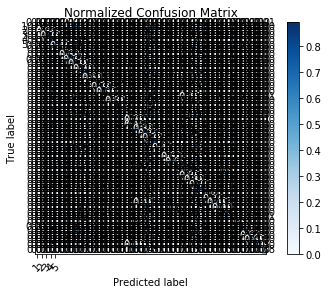

In [16]:
cm = confusion_matrix(y_test, y_pred)
evaluation.plot_confusion_matrix(cm=cm, classes=range(1, 6), normalize=True)

In [17]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Cohen's cappa coefficient:", cohen_kappa_score(y_test, y_pred))

Accuracy: 0.6921519509817178
Balanced accuracy: 0.4515646830090681
Cohen's cappa coefficient: 0.671068465442366


# Support Vector Machine (Single-Label Classification)

In [37]:
x2 = df["code_body"] + df["title"]
y2 = df["tags"].apply(lambda row: " ".join(row))

In [38]:
x2_train, x2_test, y2_train, y2_test = train_test_split(
    x2, y2, test_size=0.2, stratify=y2, random_state=30
)

In [39]:
estimators2 = [
    ('tfidf', TfidfVectorizer(tokenizer=lambda string: string.split())),
    ('clf', SGDClassifier(n_jobs=1, early_stopping=True, class_weight='balanced'))
]
parameters2 = {
    'tfidf__min_df': np.arange(10, 30, 10),
    'tfidf__max_df': np.arange(0.75, 0.9, 0.05),
    'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidf__norm': ['l1', 'l2', None]
    'clf__alpha': (1e-2, 1e-3)
}

In [40]:
p2 = Pipeline(estimators2)
grid2 = RandomizedSearchCV(
    p2,
    param_distributions=parameters2,
    scoring="balanced_accuracy",
    n_iter=20,
    cv=3,
    n_jobs=13,
    pre_dispatch="n_jobs",
)

In [41]:
score2 = grid2.fit(x2_train, y2_train)

/home/.conda-env/env_nlp_text_class/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [42]:
print(grid2.best_params_)

{'tfidf__ngram_range': (1, 1), 'tfidf__min_df': 10, 'tfidf__max_df': 0.75, 'clf__alpha': 0.001}


In [43]:
y2_pred = grid2.predict(x2_test)

In [44]:
print(classification_report(y2_test, y2_pred))

                precision    recall  f1-score   support

          .net       0.29      0.30      0.30      2690
          ajax       0.16      0.66      0.26       595
       android       0.92      0.84      0.88     29242
     angularjs       0.60      0.89      0.72      3709
        arrays       0.21      0.37      0.27       939
       asp.net       0.55      0.52      0.54      4226
   asp.net-mvc       0.49      0.68      0.57      2480
             c       0.63      0.68      0.66      6722
            c#       0.69      0.37      0.48     23217
           c++       0.84      0.64      0.73     16756
           css       0.52      0.79      0.63      4233
      database       0.19      0.42      0.26      1117
        django       0.53      0.84      0.65      2460
       eclipse       0.40      0.75      0.52      1405
         excel       0.52      0.84      0.64      3269
      facebook       0.35      0.89      0.51      1450
         forms       0.10      0.58      0.17  

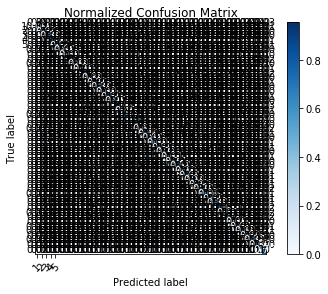

In [45]:
cm2 = confusion_matrix(y2_test, y2_pred)
evaluation.plot_confusion_matrix(cm=cm2, classes=range(1, 6), normalize=True)

In [47]:
print("Accuracy:", accuracy_score(y2_test, y2_pred))
print("Balanced accuracy:", balanced_accuracy_score(y2_test, y2_pred))
print("Cohen's cappa coefficient:", cohen_kappa_score(y2_test, y2_pred))

Accuracy: 0.6293163247519681
Balanced accuracy: 0.6272330381841831
Cohen's cappa coefficient: 0.6124788392244376


# Model Problems

<ul>
    <li>Some tags are very similar to each other</li>
    <li>Are there better features?</li>
    <li>Class imblances</li>
    <li>Hyper-parameter space must be checked and an optimization procedure better than random search should be applied</li>